In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import re
import sklearn
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Parallel, delayed
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../src')
sys.path.append(src_dir)

In [4]:
%aimport data.movielens_20m_imdb
%aimport helpers.labels

from data.movielens_20m_imdb import load_df_or_get_from_cache
from helpers.labels import truncate_labels

In [5]:
INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/movielens-ml20m-imdb/")
PATH_TO_FILE = os.path.abspath('../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-13.csv')

In [6]:
docs_df = load_df_or_get_from_cache(PATH_TO_FILE,INTERIM_DATA_ROOT)

## number of documents

In [7]:
len(docs_df)

6809

In [8]:
docs_df.head()

,movie_id,title,synopsis,tags,num_tags
0,1,Toy Story (1995),A boy called Andy Davis (voice: John Morris) u...,"disney,unlikely-friendships,fanciful,light,cgi...",62
1,2,Jumanji (1995),The film begins in 1869 in the town of Brantfo...,"scary,not-for-kids,dynamic-cgi-action,childish...",25
2,6,Heat (1995),An inbound Blue Line train pulls in to Firesto...,"great-acting,al-pacino,need-to-own,dumbed-down...",66
3,7,Sabrina (1995),"Sabrina Fairchild (Julia Ormond), is the Larra...","chick-flick,based-on-a-play,clv,drama,paris,no...",13
4,8,Tom and Huck (1995),The film opens with Injun Joe (Eric Schweig) a...,"based-on-a-book,adapted-frombook,seen,library-...",4


In [20]:
docs_df.describe(include=['number'])

,movie_id,num_tags
count,6809.000000,6809.000000
mean,41560.286973,13.934058
std,39481.710747,16.620661
min,1.000000,1.000000
25%,4169.000000,3.000000
50%,31700.000000,8.000000
75%,74789.000000,18.000000
max,131082.000000,222.000000


In [10]:
docs_df.describe(include=['object'])

,title,synopsis,tags
count,6809,6809,6809
unique,6809,6809,6315
top,Purple Noon (Plein soleil) (1960),"Gianni, Antonio and Nicola were resistant duri...",bd-r
freq,1,1,92


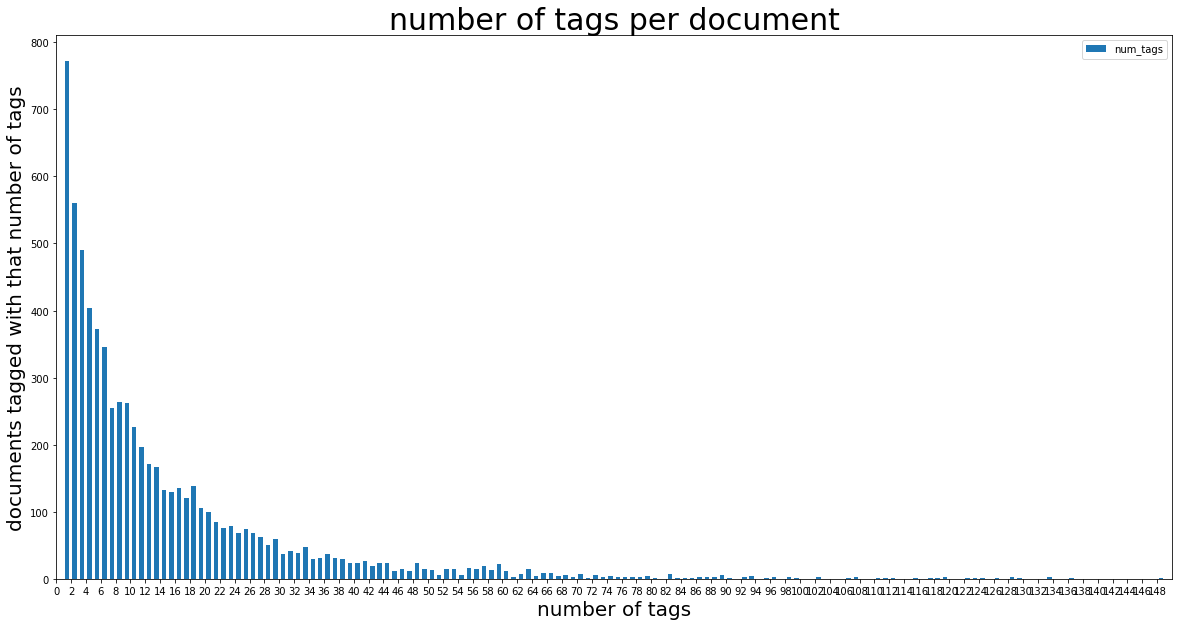

In [11]:
docs_df[['num_tags']].plot(kind='hist',bins=np.arange(1.0,150,1),rwidth=0.6)

plt.gcf().set_size_inches(20,10)
plt.gca().set_title('number of tags per document',fontsize=30)
plt.xlabel('number of tags',fontsize=20)
plt.ylabel('documents tagged with that number of tags', fontsize=20)
plt.gca().set_xlim(0,150)
plt.xticks(np.arange(0, 150, 2))
plt.show()

## number of unique tags

In [12]:
tagsets = [tagset.split(',') for tagset in docs_df["tags"].values]

flat_list = []

for tagset in tagsets:
    for tag in tagset:
        flat_list.append(tag)
        
flat_set = set(flat_list)

In [13]:
len(flat_set)

4128

## number of times each tag was given to a movie

(not counting multiple assignments)

In [14]:
labelsets = [tagset.split(',') for tagset in docs_df["tags"].values]

In [16]:
tag_assignments = MultiLabelBinarizer().fit_transform(labelsets)

In [17]:
tag_sums = tag_assignments.sum(axis=0)

Text(20,300,'$\\mu=22.98,\\ \\sigma=47.24$')

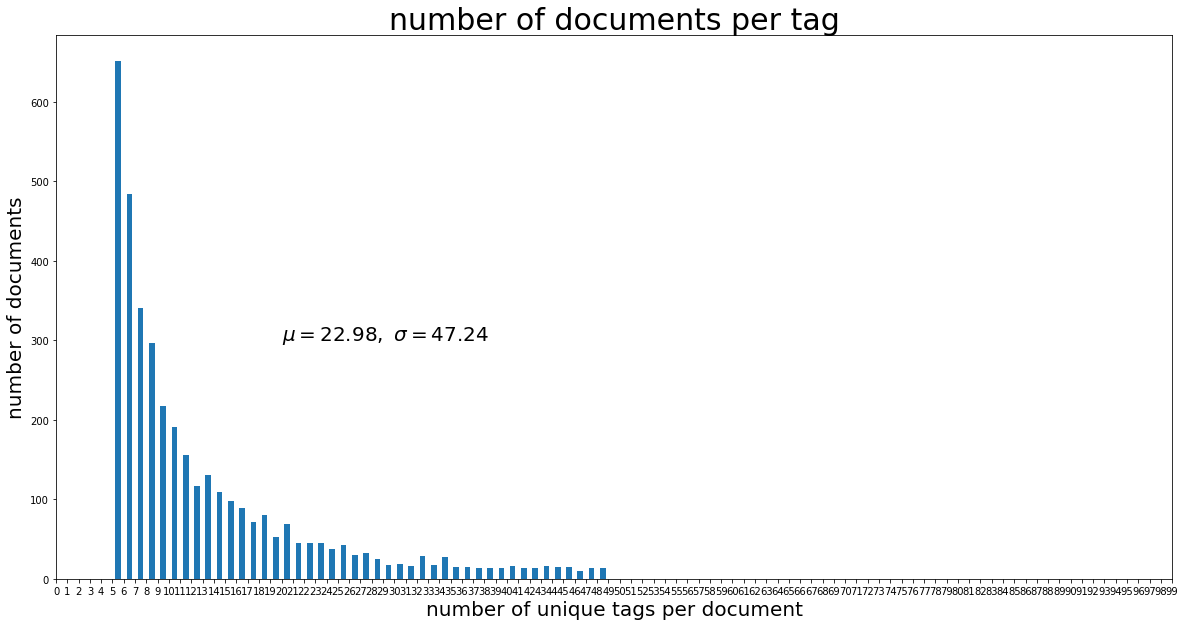

In [21]:
plt.hist(tag_sums,bins=np.arange(1.0,50,1),rwidth=0.5)

plt.gcf().set_size_inches(20,10)
plt.gca().set_title('number of documents per tag',fontsize=30)
plt.gca().set_xlim(0,50)
plt.xlabel('number of unique tags per document',fontsize=20)
plt.ylabel('number of documents', fontsize=20)
plt.xticks(np.arange(0, 100, 1))
plt.text(20,300,r'$\mu={0:.2f},\ \sigma={1:.2f}$'.format(tag_sums.mean(), tag_sums.std()), fontsize=20)

In [19]:
docs_df[docs_df['title'].str.lower().str.startswith('harry')]

,movie_id,title,synopsis,tags,num_tags
1924,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"Lord Voldemort, an evil and powerful dark wiza...","sequel,invisibility,train,rupert-grint,books,m...",66
2239,5816,Harry Potter and the Chamber of Secrets (2002),"While home with the Dursleys for the summer, H...","sequel,want-to-own,rupert-grint,literary-adapt...",48
2895,8368,Harry Potter and the Prisoner of Azkaban (2004),It opens at the Dursleys' home where Harry Pot...,"sequel,rupert-grint,hard-to-watch,maggie-smith...",44
3195,26324,Harry and Tonto (1974),As elderly people go about their day in Manhat...,"might-like,bd-r,netflix,mvlc,instant-view",5
3615,40815,Harry Potter and the Goblet of Fire (2005),"Harry, Ron and Hermione enter their fourth yea...","sequel,rupert-grint,maggie-smith,mt,jussan,pot...",56
4089,54001,Harry Potter and the Order of the Phoenix (2007),Harry Potter and his cousin Dudley Dursley are...,"rupert-grint,jussan,emma-watson,magic,adapted-...",32
4820,69844,Harry Potter and the Half-Blood Prince (2009),Scarred by his experience at the Ministry of M...,"sequel,rupert-grint,maggie-smith,direction,hig...",44
5115,74948,Harry Brown (2009),"Shot with a cellphone camera, the film opens w...","blood,organized-crime,sex,revenge,drugs,should...",20
5358,81834,Harry Potter and the Deathly Hallows: Part 1 (...,The film begins with Harry Potter (Daniel Radc...,"genocide,loyalty,wedding,snakes,rupert-grint,i...",57
5590,88125,Harry Potter and the Deathly Hallows: Part 2 (...,After burying Dobby at the garden of the Shell...,"great-acting,rupert-grint,great-cinematography...",32
